In [1]:
import os
import numpy as np
import music21 as m21
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy import stats
from scipy import spatial
from scipy import interp
import time
from collections import Counter
import math
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle

np.random.seed(777)

DIV_CONST = 64
TYPE_SCALE = 0
# 0: 0 - 0.5
# 1: 0.5 - 1
# 2: 0 - 1

# Functions

## Get Binary ROC values

In [2]:
def get_binary_ROC_values(scores_metric_and_experts_LOADED, flip_values=1.0, value_to_get=0, scale=0):
    raw_scorelist_sim_measure_BI = []
    raw_scorelist_sim_measure_unanimity_BI = []
    raw_scorelist_sim_exp_1_BI = []
    raw_scorelist_sim_exp_2_BI = []
    raw_scorelist_sim_exp_3_BI = []
    raw_scorelist_sim_exp_unanimity_BI = []

    for keyname_i in scores_metric_and_experts_LOADED.keys():
        for el in scores_metric_and_experts_LOADED[keyname_i]:
            
            sim_score = el[0] * flip_values
            exp_score_1 = el[1]
            exp_score_2 = el[2]
            exp_score_3 = el[3]
            
            raw_scorelist_sim_measure_BI.append(sim_score)
            raw_scorelist_sim_exp_1_BI.append(exp_score_1)
            raw_scorelist_sim_exp_2_BI.append(exp_score_2)
            raw_scorelist_sim_exp_3_BI.append(exp_score_3)

            # unanimity
            annotators_scores_count = dict(Counter([exp_score_1, exp_score_2, exp_score_3]))
            (max_count, max_value) = max([ (annotators_scores_count[keyname_ann], keyname_ann) for keyname_ann in annotators_scores_count ])

            if max_count != 3:
                continue
            
            # SCALE
            valid = True
            if (scale == 0): # 0 - 0.5
                if (max_value == 1):
                    valid = False
                elif (max_value == 0.5):
                    max_value = 1
                elif (max_value == 0):
                    max_value = 0
            elif (scale == 1): # 0.5 - 1.0
                if (max_value == 0):
                    valid = False
                elif (max_value == 1):
                    max_value = 1
                elif (max_value == 0.5):
                    max_value = 0
            elif (scale == 2): # 0 - 1.0
                if (max_value == 0.5):
                    valid = False
                elif (max_value == 1):
                    max_value = 1
                elif (max_value == 0):
                    max_value = 0
            
            if (not valid):
                continue
            
            raw_scorelist_sim_exp_unanimity_BI.append(max_value)
            raw_scorelist_sim_measure_unanimity_BI.append(sim_score)
            

    fpr = None
    tpr = None
    precision = None
    recall = None
    thresholds = None
    
    print("Found #{0} elements in the selected scale range".format(len(raw_scorelist_sim_exp_unanimity_BI)))
    if (value_to_get == 0): # Return unanimity Vote
        
        fpr, tpr, _ = roc_curve(raw_scorelist_sim_exp_unanimity_BI, raw_scorelist_sim_measure_unanimity_BI)
        precision, recall, thresholds = precision_recall_curve(raw_scorelist_sim_exp_unanimity_BI, raw_scorelist_sim_measure_unanimity_BI)
        
    elif (value_to_get == 1): # Return Expert 1 Vote
        
        fpr, tpr, _ = roc_curve(raw_scorelist_sim_exp_1_BI, raw_scorelist_sim_measure_BI)
        precision, recall, thresholds = precision_recall_curve(raw_scorelist_sim_exp_1_BI, raw_scorelist_sim_measure_BI)
        
    elif (value_to_get == 2): # Return Expert 2 Vote
        
        fpr, tpr, _ = roc_curve(raw_scorelist_sim_exp_2_BI, raw_scorelist_sim_measure_BI)
        precision, recall, thresholds = precision_recall_curve(raw_scorelist_sim_exp_2_BI, raw_scorelist_sim_measure_BI)
        
    elif (value_to_get == 3): # Return Expert 3 Vote
        
        fpr, tpr, _ = roc_curve(raw_scorelist_sim_exp_3_BI, raw_scorelist_sim_measure_BI)
        precision, recall, thresholds = precision_recall_curve(raw_scorelist_sim_exp_3_BI, raw_scorelist_sim_measure_BI)
        
    roc_auc = auc(fpr, tpr)
    
    numerator = 2 * recall * precision
    denom = recall + precision
    f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
    max_f1 = np.max(f1_scores)
    max_f1_thresh = thresholds[np.argmax(f1_scores)]
    
    return {"fpr":fpr, "tpr":tpr, "auc":roc_auc, "max_f1":max_f1, "max_f1_thresh":max_f1_thresh}

# READ RESULTS

In [3]:
# Store for fpr, tpr, and auc
store_roc_values = {}

## RNA

In [4]:
scores_metric_and_experts_AlRyNo = []
with open('./ROC_AlRyNo/ROC_AlRyNo_1616808383.2642221.json') as json_file:
    scores_metric_and_experts_AlRyNo = json.load(json_file)

In [5]:
SIM_NAME = "RNA"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_AlRyNo, flip_values=1.0, value_to_get=0, scale=TYPE_SCALE)
print(store_roc_values[SIM_NAME]["max_f1"])
print(store_roc_values[SIM_NAME]["max_f1_thresh"])

Found #22476 elements in the selected scale range
0.7048473348283595
0.4166666666666667


## Euclidean Distance

In [6]:
scores_metric_and_experts_ED = []
with open('./ROC_ED/ROC_ED_1616776608.1142232.json') as json_file:
    scores_metric_and_experts_ED = json.load(json_file)

In [7]:
SIM_NAME = "ED"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_ED, flip_values=1.0, value_to_get=0, scale=TYPE_SCALE)
print(store_roc_values[SIM_NAME]["max_f1"])
print(store_roc_values[SIM_NAME]["max_f1_thresh"])

Found #22476 elements in the selected scale range
0.6508977361436379
0.7100226978096958


## City Block Distance

In [8]:
scores_metric_and_experts_CBD = []
with open('./ROC_CBD/ROC_CBD_1616777022.3399668.json') as json_file:
    scores_metric_and_experts_CBD = json.load(json_file)

In [9]:
SIM_NAME = "CBD"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_CBD, flip_values=1.0, value_to_get=0, scale=TYPE_SCALE)
print(store_roc_values[SIM_NAME]["max_f1"])
print(store_roc_values[SIM_NAME]["max_f1_thresh"])

Found #22476 elements in the selected scale range
0.6518507046616077
1.3333333333333333


## Correlation

In [10]:
scores_metric_and_experts_CORR = []
with open('./ROC_CORR/ROC_CORR_1616777242.431047.json') as json_file:
    scores_metric_and_experts_CORR = json.load(json_file)

In [11]:
SIM_NAME = "CORR"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_CORR, flip_values=1.0, value_to_get=0, scale=TYPE_SCALE)
print(store_roc_values[SIM_NAME]["max_f1"])
print(store_roc_values[SIM_NAME]["max_f1_thresh"])

Found #22476 elements in the selected scale range
0.6706959074425833
0.025638056375367417


## Local Alignment

In [12]:
scores_metric_and_experts_LA = []
with open('./ROC_LA/ROC_LA_1616779426.8688939.json') as json_file:
    scores_metric_and_experts_LA = json.load(json_file)

In [13]:
SIM_NAME = "LA"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_LA, flip_values=-1.0, value_to_get=0, scale=TYPE_SCALE)
print(store_roc_values[SIM_NAME]["max_f1"])
print(store_roc_values[SIM_NAME]["max_f1_thresh"])

Found #22476 elements in the selected scale range
0.7394343674327226
-5.5


## SIAM

In [14]:
scores_metric_and_experts_SIAM = []
with open('./ROC_SIAM/ROC_SIAM_1616781945.8996937.json') as json_file:
    scores_metric_and_experts_SIAM = json.load(json_file)

In [15]:
SIM_NAME = "SIAM"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_SIAM, flip_values=-1.0, value_to_get=0, scale=TYPE_SCALE)
print(store_roc_values[SIM_NAME]["max_f1"])
print(store_roc_values[SIM_NAME]["max_f1_thresh"])

Found #22476 elements in the selected scale range
0.831484195101528
-0.5714285714285714


## BSPLINE

In [16]:
scores_metric_and_experts_BSPLINE = []
with open('./ROC_BSPLINE/ROC_BSPLINE_1616799793.9739344.json') as json_file:
    scores_metric_and_experts_BSPLINE = json.load(json_file)

In [17]:
SIM_NAME = "BSPLINE"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_BSPLINE, flip_values=-1.0, value_to_get=0, scale=TYPE_SCALE)
print(store_roc_values[SIM_NAME]["max_f1"])
print(store_roc_values[SIM_NAME]["max_f1_thresh"])

Found #22476 elements in the selected scale range
0.790261359939269
-0.26190476


# BINARY ROC PLOT

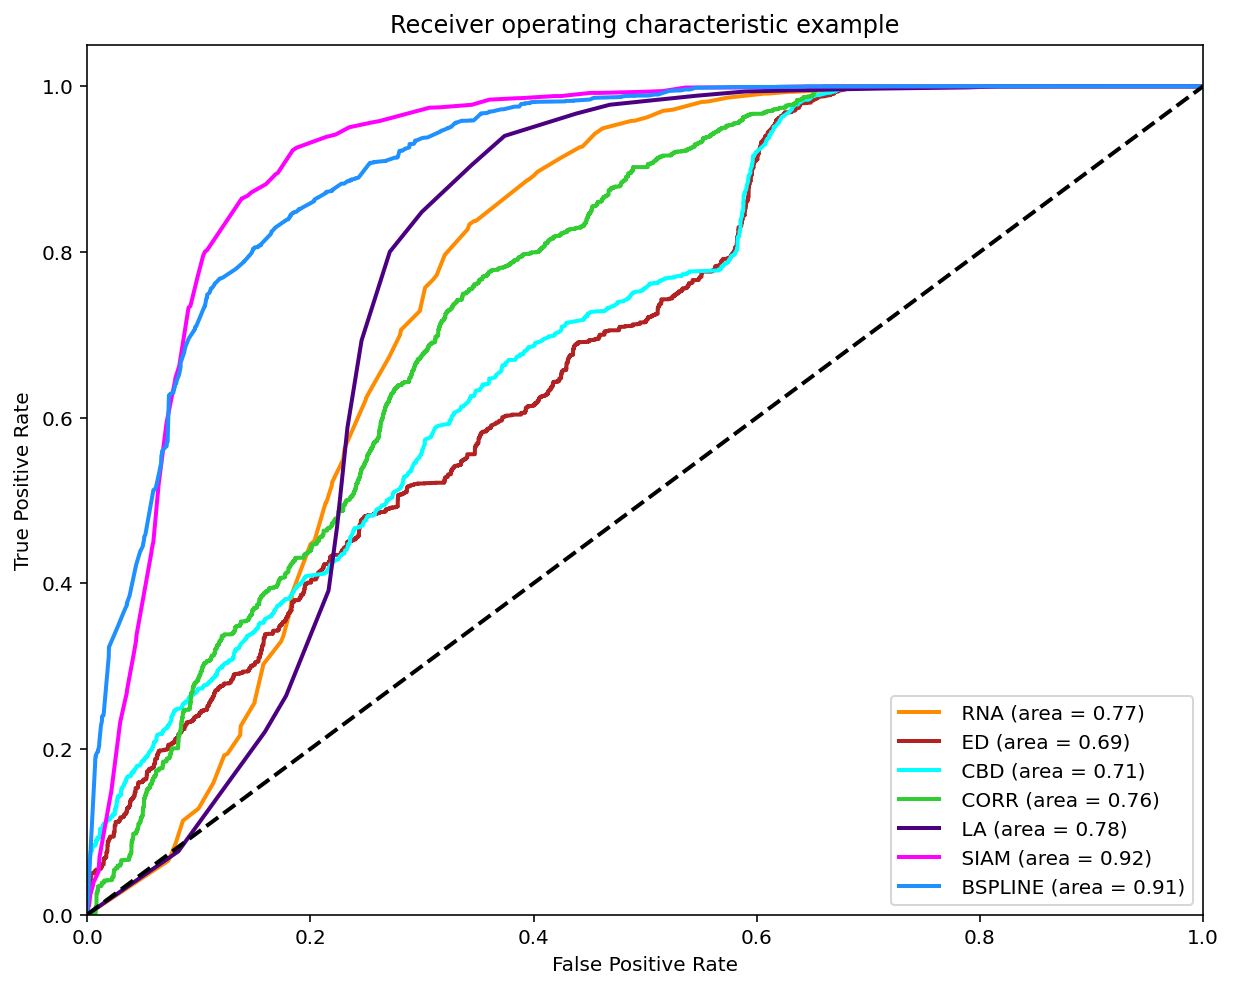

In [18]:
plt.figure(figsize=(10,8))
lw = 2

colors = ['darkorange', 'firebrick', 'cyan', 'limegreen', 'indigo', 'magenta', 'dodgerblue']
method_name_keys = list(store_roc_values.keys())
for i, color in zip(range(len(method_name_keys)), colors):
    method_name = method_name_keys[i]
    plt.plot(store_roc_values[method_name]["fpr"], store_roc_values[method_name]["tpr"], color=color, lw=lw,
             label=' {0} (area = {1:0.2f})'
             ''.format(method_name, store_roc_values[method_name]["auc"]))

plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Majority

Found 37540 elements in the selected scale range (0 - 0.5)

Found 127144 elements in the selected scale range (0.5 - 1)

Found 130304 elements in the selected scale range (0 - 1)

# BINARY BEST F1 SCORES

In [19]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Text(0.5, 1.0, 'Best F1 Scores')

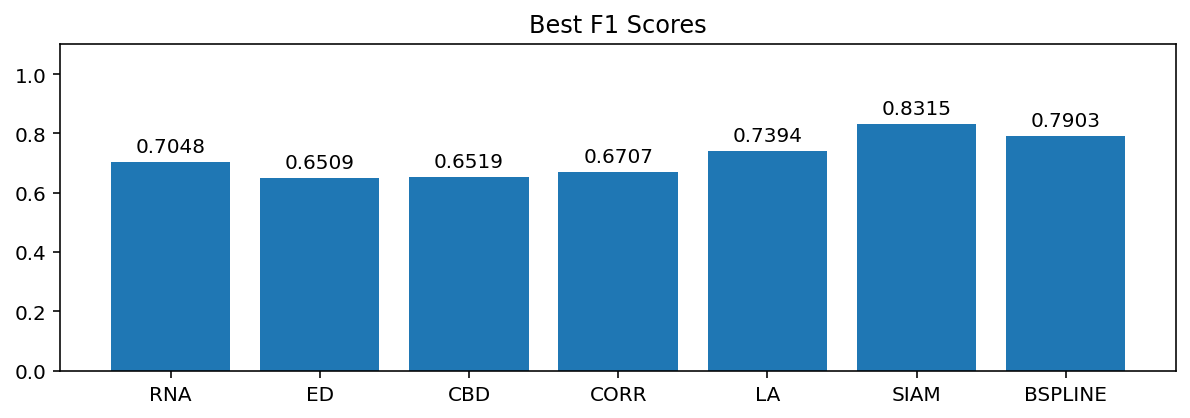

In [20]:
fig, ax = plt.subplots(figsize=(10,3))

method_name_keys = list(store_roc_values.keys())
rects1 = ax.bar(method_name_keys, [store_roc_values[m_name]["max_f1"] for m_name in method_name_keys])
ax.set_ylim(0,1.1)
# plt.bar(method_name_keys, [store_roc_values[m_name]["max_f1"] for m_name in method_name_keys])
# ax.set_ylabel('F1 Scores')
autolabel(rects1)
ax.set_title('Best F1 Scores')